worm1

📊 データ統計:
最小値: -0.2141
第1四分位数: 0.0227
中央値: 0.0515
第3四分位数: 0.4124
最大値: 0.7191
平均値: 0.0625
標準偏差: 0.0634


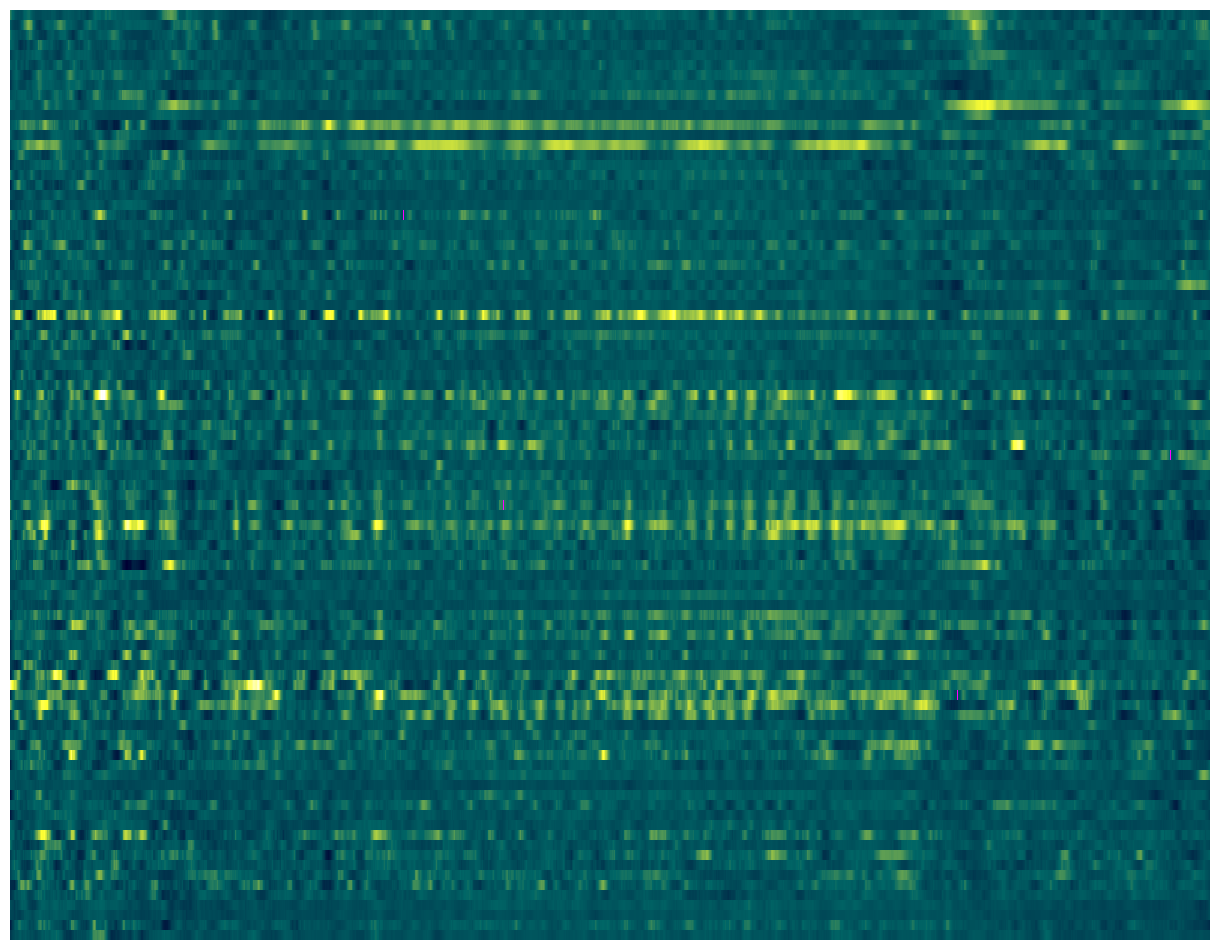

✅ 4色カラーマップ作成完了
カラースケール範囲: -0.2141 ～ 0.7191
✅ ヒートマップデータをCSV保存: output_heatmaps\20250819\heatmap_20240508-185610tdTomato-10mW-1good.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from datetime import datetime

# === データ読み込み ===
df = pd.read_csv("ratio_10mW-1_good.csv")
time = df['timing'].to_numpy()
cell_labels = [col for col in df.columns if col.startswith("cell")]

# === ΔR/R₀ 計算関数 ===
def compute_dR_R0(series, method="percentile10"):
    if method.startswith("percentile"):
        p = int(method.replace("percentile", ""))
        R0 = np.nanpercentile(series, p)
        return (series - R0) / R0
    else:
        raise ValueError(f"Unsupported method: {method}")

# === 4色指定カラーマップ作成関数 ===
def create_four_color_cmap(data, colors, n_colors=256):
    """
    データの範囲を4等分し、4色でグラデーションを作成
    
    Parameters:
    -----------
    data : array-like
        データ配列
    colors : list of 4 colors
        [最小値色, 中間低色, 中間高色, 最大値色]
        各色は [R, G, B] の形式 (0-1の範囲)
    n_colors : int
        カラーマップの色数
        
    Returns:
    --------
    cmap : ListedColormap
        カスタムカラーマップ
    vmin, vmax : float
        データの最小値、最大値
    quartiles : list
        4分位点のリスト
    """
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    
    # 4つの分位点を計算
    q1 = np.nanpercentile(data, 25)   # 第1四分位数
    q2 = np.nanpercentile(data, 50)   # 第2四分位数（中央値）
    q3 = np.nanpercentile(data, 75)   # 第3四分位数
    quartiles = [vmin, q1, q2, q3, vmax]
    
    # 各区間のピクセル数を計算
    segment_size = n_colors // 4
    remaining = n_colors % 4
    
    segments = [segment_size] * 4
    for i in range(remaining):
        segments[i] += 1
    
    # 4色を配列に変換
    color1 = np.array(colors[0])  # 最小値色
    color2 = np.array(colors[1])  # 中間低色
    color3 = np.array(colors[2])  # 中間高色
    color4 = np.array(colors[3])  # 最大値色
    
    # 各区間のグラデーションを作成
    gradients = []
    
    # 区間1: color1 → color2
    if segments[0] > 0:
        grad1 = np.array([
            color1 * (1 - t) + color2 * t 
            for t in np.linspace(0, 1, segments[0])
        ])
        gradients.append(grad1)
    
    # 区間2: color2 → color3
    if segments[1] > 0:
        grad2 = np.array([
            color2 * (1 - t) + color3 * t 
            for t in np.linspace(0, 1, segments[1])
        ])
        gradients.append(grad2)
    
    # 区間3: color3 → color4
    if segments[2] > 0:
        grad3 = np.array([
            color3 * (1 - t) + color4 * t 
            for t in np.linspace(0, 1, segments[2])
        ])
        gradients.append(grad3)
    
    # 区間4: 最終区間（必要に応じて）
    if segments[3] > 0:
        grad4 = np.array([color4] * segments[3])  # 最大値色で一定
        gradients.append(grad4)
    
    # 全グラデーションを結合
    full_gradient = np.vstack(gradients)
    
    return ListedColormap(full_gradient, name="four_color_cmap"), vmin, vmax, quartiles


# === 4色指定カラーマップ作成関数（NaN値対応版）===
def create_four_color_cmap_narrow_max(data, colors, white_threshold=0.95, n_colors=256):
    """
    データの最上位パーセンタイル以上のみ最大値色（白）にする版
    NaN値は真っ黒で表示
    """
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    
    # 白色の閾値を計算
    white_value = np.nanpercentile(data, white_threshold * 100)
    
    # 4つの分位点を計算（白色閾値以下の範囲で）
    q1 = np.nanpercentile(data, 25)
    q2 = np.nanpercentile(data, 50) 
    q3 = white_value  # 第3四分位数を白色閾値に設定
    quartiles = [vmin, q1, q2, q3, vmax]
    
    # 各区間のピクセル数を計算
    white_pixels = int(n_colors * (1 - white_threshold))  # 白色のピクセル数
    gradient_pixels = n_colors - white_pixels
    segment_size = gradient_pixels // 3
    
    segments = [segment_size] * 3 + [white_pixels]
    
    # 残りのピクセルを分配
    remaining = gradient_pixels % 3
    for i in range(remaining):
        segments[i] += 1
    
    # 4色を配列に変換
    color1 = np.array(colors[0])  # 最小値色
    color2 = np.array(colors[1])  # 中間低色
    color3 = np.array(colors[2])  # 中間高色
    color4 = np.array(colors[3])  # 最大値色（白）
    
    # 各区間のグラデーションを作成
    gradients = []
    
    # 区間1: color1 → color2
    if segments[0] > 0:
        grad1 = np.array([
            color1 * (1 - t) + color2 * t 
            for t in np.linspace(0, 1, segments[0])
        ])
        gradients.append(grad1)
    
    # 区間2: color2 → color3
    if segments[1] > 0:
        grad2 = np.array([
            color2 * (1 - t) + color3 * t 
            for t in np.linspace(0, 1, segments[1])
        ])
        gradients.append(grad2)
    
    # 区間3: color3 → color4（グラデーション）
    if segments[2] > 0:
        grad3 = np.array([
            color3 * (1 - t) + color4 * t 
            for t in np.linspace(0, 1, segments[2])
        ])
        gradients.append(grad3)
    
    # 区間4: 純粋な最大値色（白）- 狭い範囲
    if segments[3] > 0:
        grad4 = np.array([color4] * segments[3])
        gradients.append(grad4)
    
    # 全グラデーションを結合
    full_gradient = np.vstack(gradients)
    
    # カラーマップ作成（NaN値を真っ黒に設定）
    cmap = ListedColormap(full_gradient, name="four_color_narrow_max")
    # cmap.set_bad(color='black')  # NaN値を真っ黒に設定
    cmap.set_bad(color='magenta')  # NaN値をマゼンタに設定
    return cmap, vmin, vmax, quartiles



# === データ処理 ===
dR_R0 = np.array([compute_dR_R0(df[cell]) for cell in cell_labels])

# === セルソート ===
priority_cells = [
    "cell85", "cell87", "cell123", "cell136", "cell40", "cell24", "cell30", "cell37",
    "cell141", "cell78", "cell111", "cell135", "cell73", "cell48", "cell148", "cell60", "cell58"
]
cell_label_nums = [int(c[4:]) for c in cell_labels]
label_to_index = {int(c[4:]): i for i, c in enumerate(cell_labels)}
priority_indices = [label_to_index[int(c[4:])] for c in priority_cells if int(c[4:]) in label_to_index]
remaining_indices = sorted(set(range(len(cell_labels))) - set(priority_indices), key=lambda i: cell_label_nums[i])
final_indices = priority_indices + remaining_indices
sorted_data = dR_R0[final_indices]
sorted_labels = [cell_labels[i] for i in final_indices]

# === 4色の定義 ===
white = np.array([1.0, 1.0, 1.0])
bright_yellow = np.array([1.0, 1.0, 0.2]) 
dark_cyan = np.array([0.0, 0.4, 0.4])
super_dark_blue = np.array([0.0, 0.0, 0.2])

# 例1: 青系統から黄色系統
colors_example1 = [
    super_dark_blue,    # 濃い青（最小値）
    dark_cyan,    # 明るい青（第1四分位）
    bright_yellow,    # 薄い黄色（第3四分位）
    white     # 濃い黄色（最大値）
]

# 例2: 紫から緑
colors_example2 = [
    [0.4, 0.0, 0.6],    # 濃い紫（最小値）
    [0.7, 0.4, 1.0],    # 薄い紫（第1四分位）
    [0.6, 0.9, 0.4],    # 薄い緑（第3四分位）
    [0.0, 0.6, 0.0]     # 濃い緑（最大値）
]

# 例3: グレースケール系
colors_example3 = [
    [0.1, 0.1, 0.1],    # 黒（最小値）
    [0.4, 0.4, 0.4],    # 暗いグレー（第1四分位）
    [0.7, 0.7, 0.7],    # 明るいグレー（第3四分位）
    [0.95, 0.95, 0.95]  # 白に近い（最大値）
]

# 使用する色セットを選択
selected_colors = colors_example1  # ここを変更して色を選択

# === 4色カラーマップ作成 ===
# custom_cmap, vmin, vmax, quartiles = create_four_color_cmap(sorted_data, selected_colors)
custom_cmap, vmin, vmax, quartiles = create_four_color_cmap_narrow_max(
    sorted_data, selected_colors, white_threshold=0.999
)

# === データ統計情報表示 ===
print("📊 データ統計:")
print(f"最小値: {vmin:.4f}")
print(f"第1四分位数: {quartiles[1]:.4f}")
print(f"中央値: {quartiles[2]:.4f}")
print(f"第3四分位数: {quartiles[3]:.4f}")
print(f"最大値: {vmax:.4f}")
print(f"平均値: {np.nanmean(sorted_data):.4f}")
print(f"標準偏差: {np.nanstd(sorted_data):.4f}")

# === ヒートマップ描画 ===
fig, ax = plt.subplots(figsize=(12, 0.1 * len(sorted_labels)))
im = ax.imshow(sorted_data, aspect='auto', cmap=custom_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
# ax.set_yticks(np.arange(len(sorted_labels)))
# ax.set_yticklabels(sorted_labels, fontsize=8)
# ax.set_xticks([])
ax.axis('off')
# プロット領域を図全体に設定
ax.set_position([0, 0, 1, 1])

# # カラーバー
# cbar = fig.colorbar(im, ax=ax, fraction=0.015, pad=0.01)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('ΔR/R₀', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

# === 画像保存 ===
date_str = datetime.now().strftime("%Y%m%d")
output_dir = os.path.join("output_heatmaps", date_str)
os.makedirs(output_dir, exist_ok=True)

dpi=600
fig.savefig(
    os.path.join(
        output_dir,
        f"heatmap_20240508-185610tdTomato-10mW-1good.tiff"
    ),
    dpi=dpi,
    bbox_inches='tight',
    pad_inches=0.0,  # パディングを0に設定
    format='tiff',
    edgecolor='none',                       # エッジなし
    pil_kwargs={                                
        "compression": "none",                  # 完全非圧縮
        "optimize": False,                       # 最適化無効（品質優先）
        "dpi": (dpi, dpi)
    }
)

print(f"✅ 4色カラーマップ作成完了")
print(f"カラースケール範囲: {vmin:.4f} ～ {vmax:.4f}")

# === ヒートマップデータをCSV保存 ===
# # 時刻データを読み込み
# timestamp_path = r"G:\tracking_stage_materials_shishido\orig\20240508-185610tdTomato-10mW-1good\3Dtimestamp_relative_10vps.csv"
# timestamp_df = pd.read_csv(timestamp_path, header=None)
# timestamps = timestamp_df.iloc[1:, 0].to_numpy()

# 保存用DataFrame作成
# csv_df = pd.DataFrame(sorted_data, index=sorted_labels, columns=timestamps)
csv_df = pd.DataFrame(sorted_data, index=sorted_labels)
# csv_df.index.name = "Neuron"

# ★ 修正: index（セル名）を Neuron1, Neuron2, ... に変更
neuron_labels = [f"Neuron{i+1}" for i in range(len(sorted_labels))]
csv_df.index = neuron_labels

# CSV保存（index=Trueでセル名を1列目に含める）
csv_save_path = os.path.join(output_dir, "heatmap_20240508-185610tdTomato-10mW-1good.csv")
csv_df.to_csv(csv_save_path, index=True, header=False)  # index=True に変更
print(f"✅ ヒートマップデータをCSV保存: {csv_save_path}")

Change the maximum value assigned to the upper color

Worm2,ratio_12mW-3_v2

✅ 手動vmax使用: 白色閾値 = 1.700
⚠️ 警告: 203 ピクセルがvmax(1.700)を超過
   → これらは白色で表示されます
cell_labels with data values above vmax: ['cell8', 'cell114']


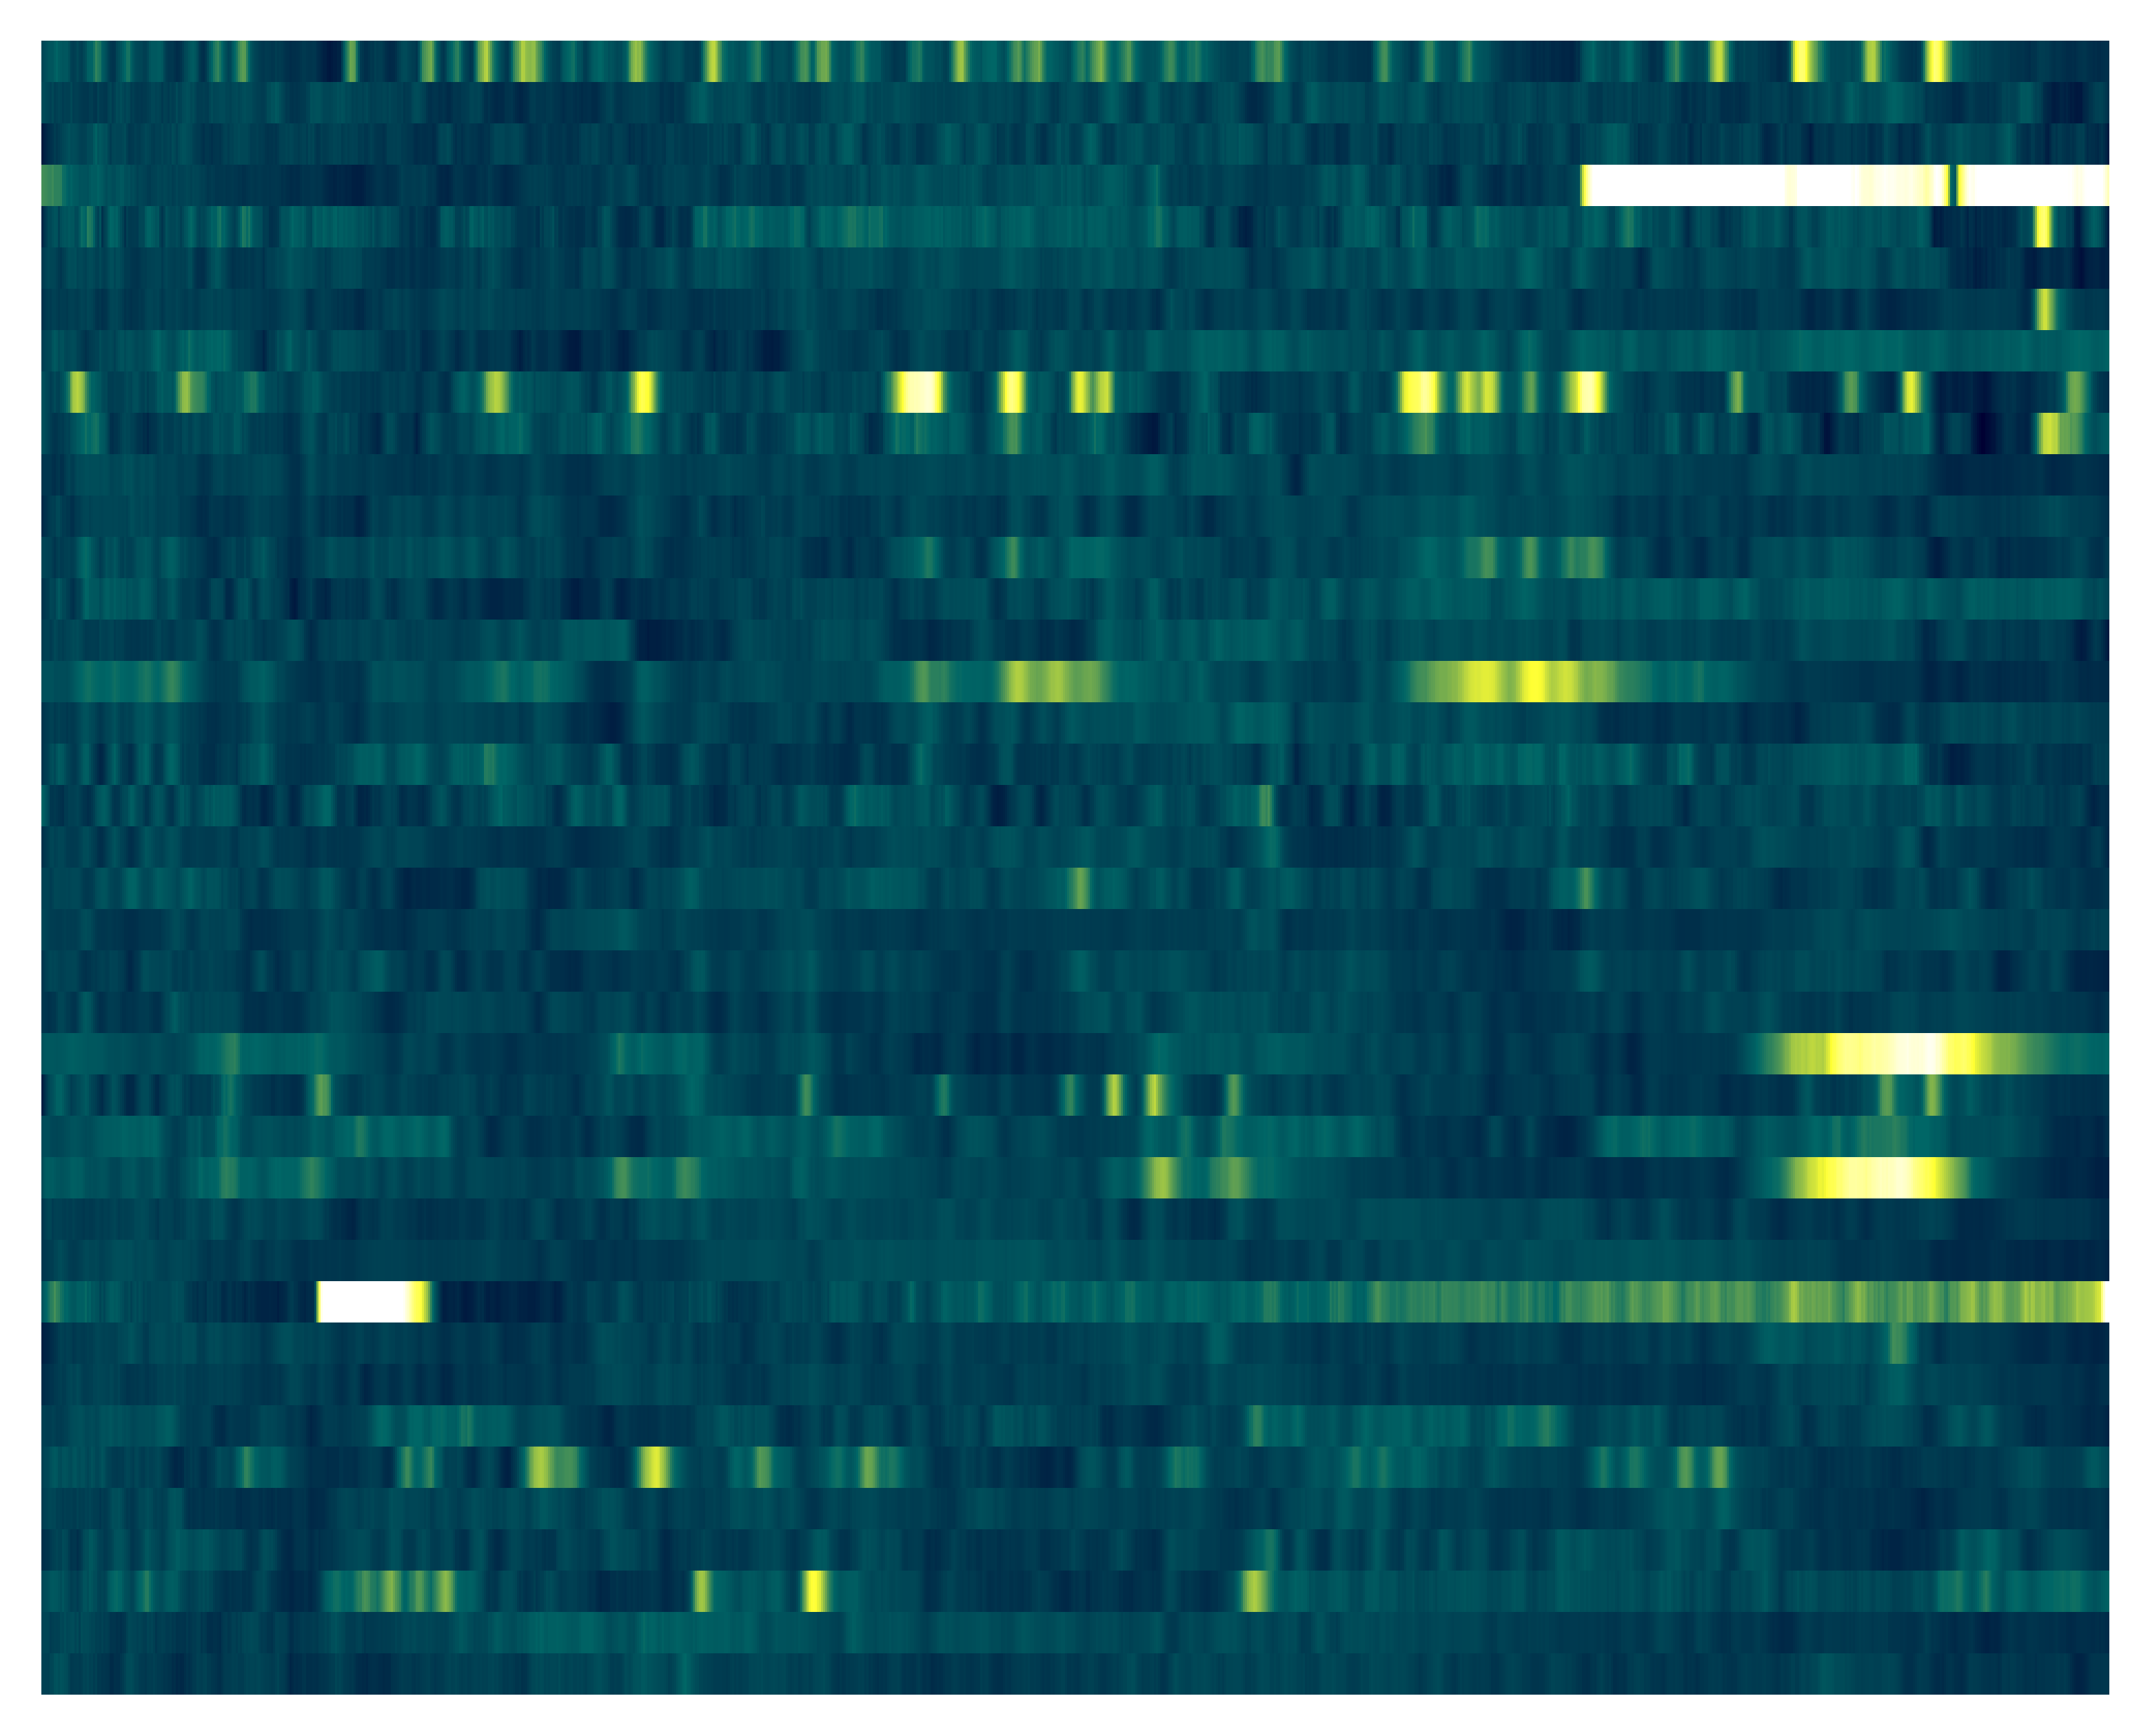

✅ ヒートマップデータをCSV保存: output_heatmaps\20250819\heatmap_ratio_12mW-3_v2_bleach_corrected_win7_pNaN.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from datetime import datetime

# === データ読み込み ===
filename = "ratio_12mW-3_v2_bleach_corrected_win7_pNaN"
df = pd.read_csv(f"{filename}.csv")
time = df['timing'].to_numpy()
cell_labels = [col for col in df.columns if col.startswith("cell")]

# === ΔR/R₀ 計算関数 ===
def compute_dR_R0(series, method="percentile10"):
    if method.startswith("percentile"):
        p = int(method.replace("percentile", ""))
        R0 = np.nanpercentile(series, p)
        return (series - R0) / R0
    else:
        raise ValueError(f"Unsupported method: {method}")


# === 4色指定カラーマップ作成関数（NaN値対応版）===
def create_four_color_cmap_narrow_max_fixed(data, colors, white_threshold=1, vmin=None, vmax=None, n_colors=256):
    """
    手動vmax設定に対応した修正版
    """
    
    # vmin, vmaxが指定されていない場合はデータから計算
    if vmin is None:
        vmin = np.nanmin(data)
    if vmax is None:
        vmax = np.nanmax(data)
    
    # 白色閾値の計算（vmaxとの整合性を保つ）
    data_max = np.nanmax(data)
    
    if white_threshold == 1.0:
        # white_threshold=1.0の場合、vmaxを白色閾値として使用
        white_value = vmax
        print(f"✅ 手動vmax使用: 白色閾値 = {white_value:.3f}")
    else:
        # white_threshold < 1.0の場合、データから計算
        white_value = np.nanpercentile(data, white_threshold * 100)
        # ただし、vmaxを超えないように制限
        white_value = min(white_value, vmax)
        print(f"✅ 調整後白色閾値: {white_value:.3f} (制限: vmax={vmax:.3f})")
    
    # vmaxを超えるデータの警告
    over_vmax_count = np.sum(data > vmax)
    if over_vmax_count > 0:
        print(f"⚠️ 警告: {over_vmax_count} ピクセルがvmax({vmax:.3f})を超過")
        print(f"   → これらは白色で表示されます")
    
    # 四分位点計算（vmin～vmax範囲内で）
    clipped_data = np.clip(data, vmin, vmax)
    q1 = np.nanpercentile(clipped_data, 25)
    q2 = np.nanpercentile(clipped_data, 50)
    q3 = white_value
    quartiles = [vmin, q1, q2, q3, vmax]
    
    # 区間のピクセル数計算
    if white_threshold == 1.0:
        # 最大値のみ白色の場合
        white_pixels = max(1, int(n_colors * 0.01))  # 最低1%は白色用に確保
    else:
        white_pixels = int(n_colors * (1 - white_threshold))
    
    gradient_pixels = n_colors - white_pixels
    segment_size = gradient_pixels // 3
    
    segments = [segment_size] * 3 + [white_pixels]
    
    # 残りの分配
    remaining = gradient_pixels % 3
    for i in range(remaining):
        segments[i] += 1
    
    # 色の配列
    color1 = np.array(colors[0])  # 最小値色
    color2 = np.array(colors[1])  # 中間低色
    color3 = np.array(colors[2])  # 中間高色
    color4 = np.array(colors[3])  # 最大値色（白）
    
    # グラデーション作成
    gradients = []
    
    for i, (start_color, end_color, seg_size) in enumerate([
        (color1, color2, segments[0]),
        (color2, color3, segments[1]),
        (color3, color4, segments[2])
    ]):
        if seg_size > 0:
            grad = np.array([
                start_color * (1 - t) + end_color * t 
                for t in np.linspace(0, 1, seg_size)
            ])
            gradients.append(grad)
    
    # 白色区間
    if segments[3] > 0:
        grad4 = np.array([color4] * segments[3])
        gradients.append(grad4)
    
    # カラーマップ作成
    full_gradient = np.vstack(gradients)
    cmap = ListedColormap(full_gradient, name="four_color_narrow_max_fixed")
    cmap.set_bad(color='magenta')
    
    return cmap, vmin, vmax, quartiles


# === データ処理 ===
dR_R0 = np.array([compute_dR_R0(df[cell]) for cell in cell_labels])

# === セルソート ===
cell_label_nums = [int(c[4:]) for c in cell_labels]
label_to_index = {int(c[4:]): i for i, c in enumerate(cell_labels)}

# === 4色の定義 ===
white = np.array([1.0, 1.0, 1.0])
bright_yellow = np.array([1.0, 1.0, 0.2]) 
dark_cyan = np.array([0.0, 0.4, 0.4])
super_dark_blue = np.array([0.0, 0.0, 0.2])

# 使用する色セットを選択
selected_colors = [
    super_dark_blue,    # 濃い青（最小値）
    dark_cyan,    # 明るい青（第1四分位）
    bright_yellow,    # 薄い黄色（第3四分位）
    white     # 濃い黄色（最大値）
]

# === 修正版の使用例 ===
# 手動設定での使用
white_threshold = 1.0
vmin = np.nanmin(dR_R0)
vmax = 1.7  # 手動設定

custom_cmap, vmin, vmax, quartiles = create_four_color_cmap_narrow_max_fixed(
    dR_R0, selected_colors, 
    white_threshold=white_threshold, 
    vmin=vmin, 
    vmax=vmax, 
    n_colors=256
)

over_vmax_cells = []
for i, cell in enumerate(cell_labels):
    if np.any(dR_R0[i] > vmax):
        over_vmax_cells.append(cell)
print("cell_labels with data values above vmax:", over_vmax_cells)

# === ヒートマップ描画 ===
fig, ax = plt.subplots(figsize=(5, 4), dpi=600)
im = ax.imshow(dR_R0, aspect='auto', cmap=custom_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
# ax.set_title(f"cell_labels with data values above vmax:{over_vmax_cells}", fontsize=3)
# ax.set_yticks(np.arange(len(cell_labels)))
# ax.set_yticklabels(cell_labels, fontsize=3)
# ax.set_xticks([])
ax.axis('off')
# プロット領域を図全体に設定
ax.set_position([0, 0, 1, 1])

# # カラーバー
# cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('ΔR/R₀', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

# === 画像保存 ===
date_str = datetime.now().strftime("%Y%m%d")
output_dir = os.path.join("output_heatmaps", date_str)
os.makedirs(output_dir, exist_ok=True)

dpi=600
fig.savefig(
    os.path.join(
        output_dir,
        f"{filename}_vmax_{vmax}.tiff"
    ),
    dpi=dpi,
    bbox_inches='tight',
    pad_inches=0.0,  # パディングを0に設定
    format='tiff',
    edgecolor='none',                       # エッジなし
    pil_kwargs={                                
        "compression": "none",                  # 完全非圧縮
        "optimize": False,                       # 最適化無効（品質優先）
        "dpi": (dpi, dpi)
    }
)

csv_df = pd.DataFrame(dR_R0, index=cell_labels)
neuron_labels = [f"Neuron{i+1}" for i in range(len(cell_labels))]
csv_df.index = neuron_labels
csv_save_path = os.path.join(output_dir, f"heatmap_{filename}.csv")
csv_df.to_csv(csv_save_path, index=True, header=False)  # index=True に変更
print(f"✅ ヒートマップデータをCSV保存: {csv_save_path}")

Worm3,ratio_10mW-4_v2

✅ 手動vmax使用: 白色閾値 = 1.300
⚠️ 警告: 127 ピクセルがvmax(1.300)を超過
   → これらは白色で表示されます
cell_labels with data values above vmax: ['cell3']


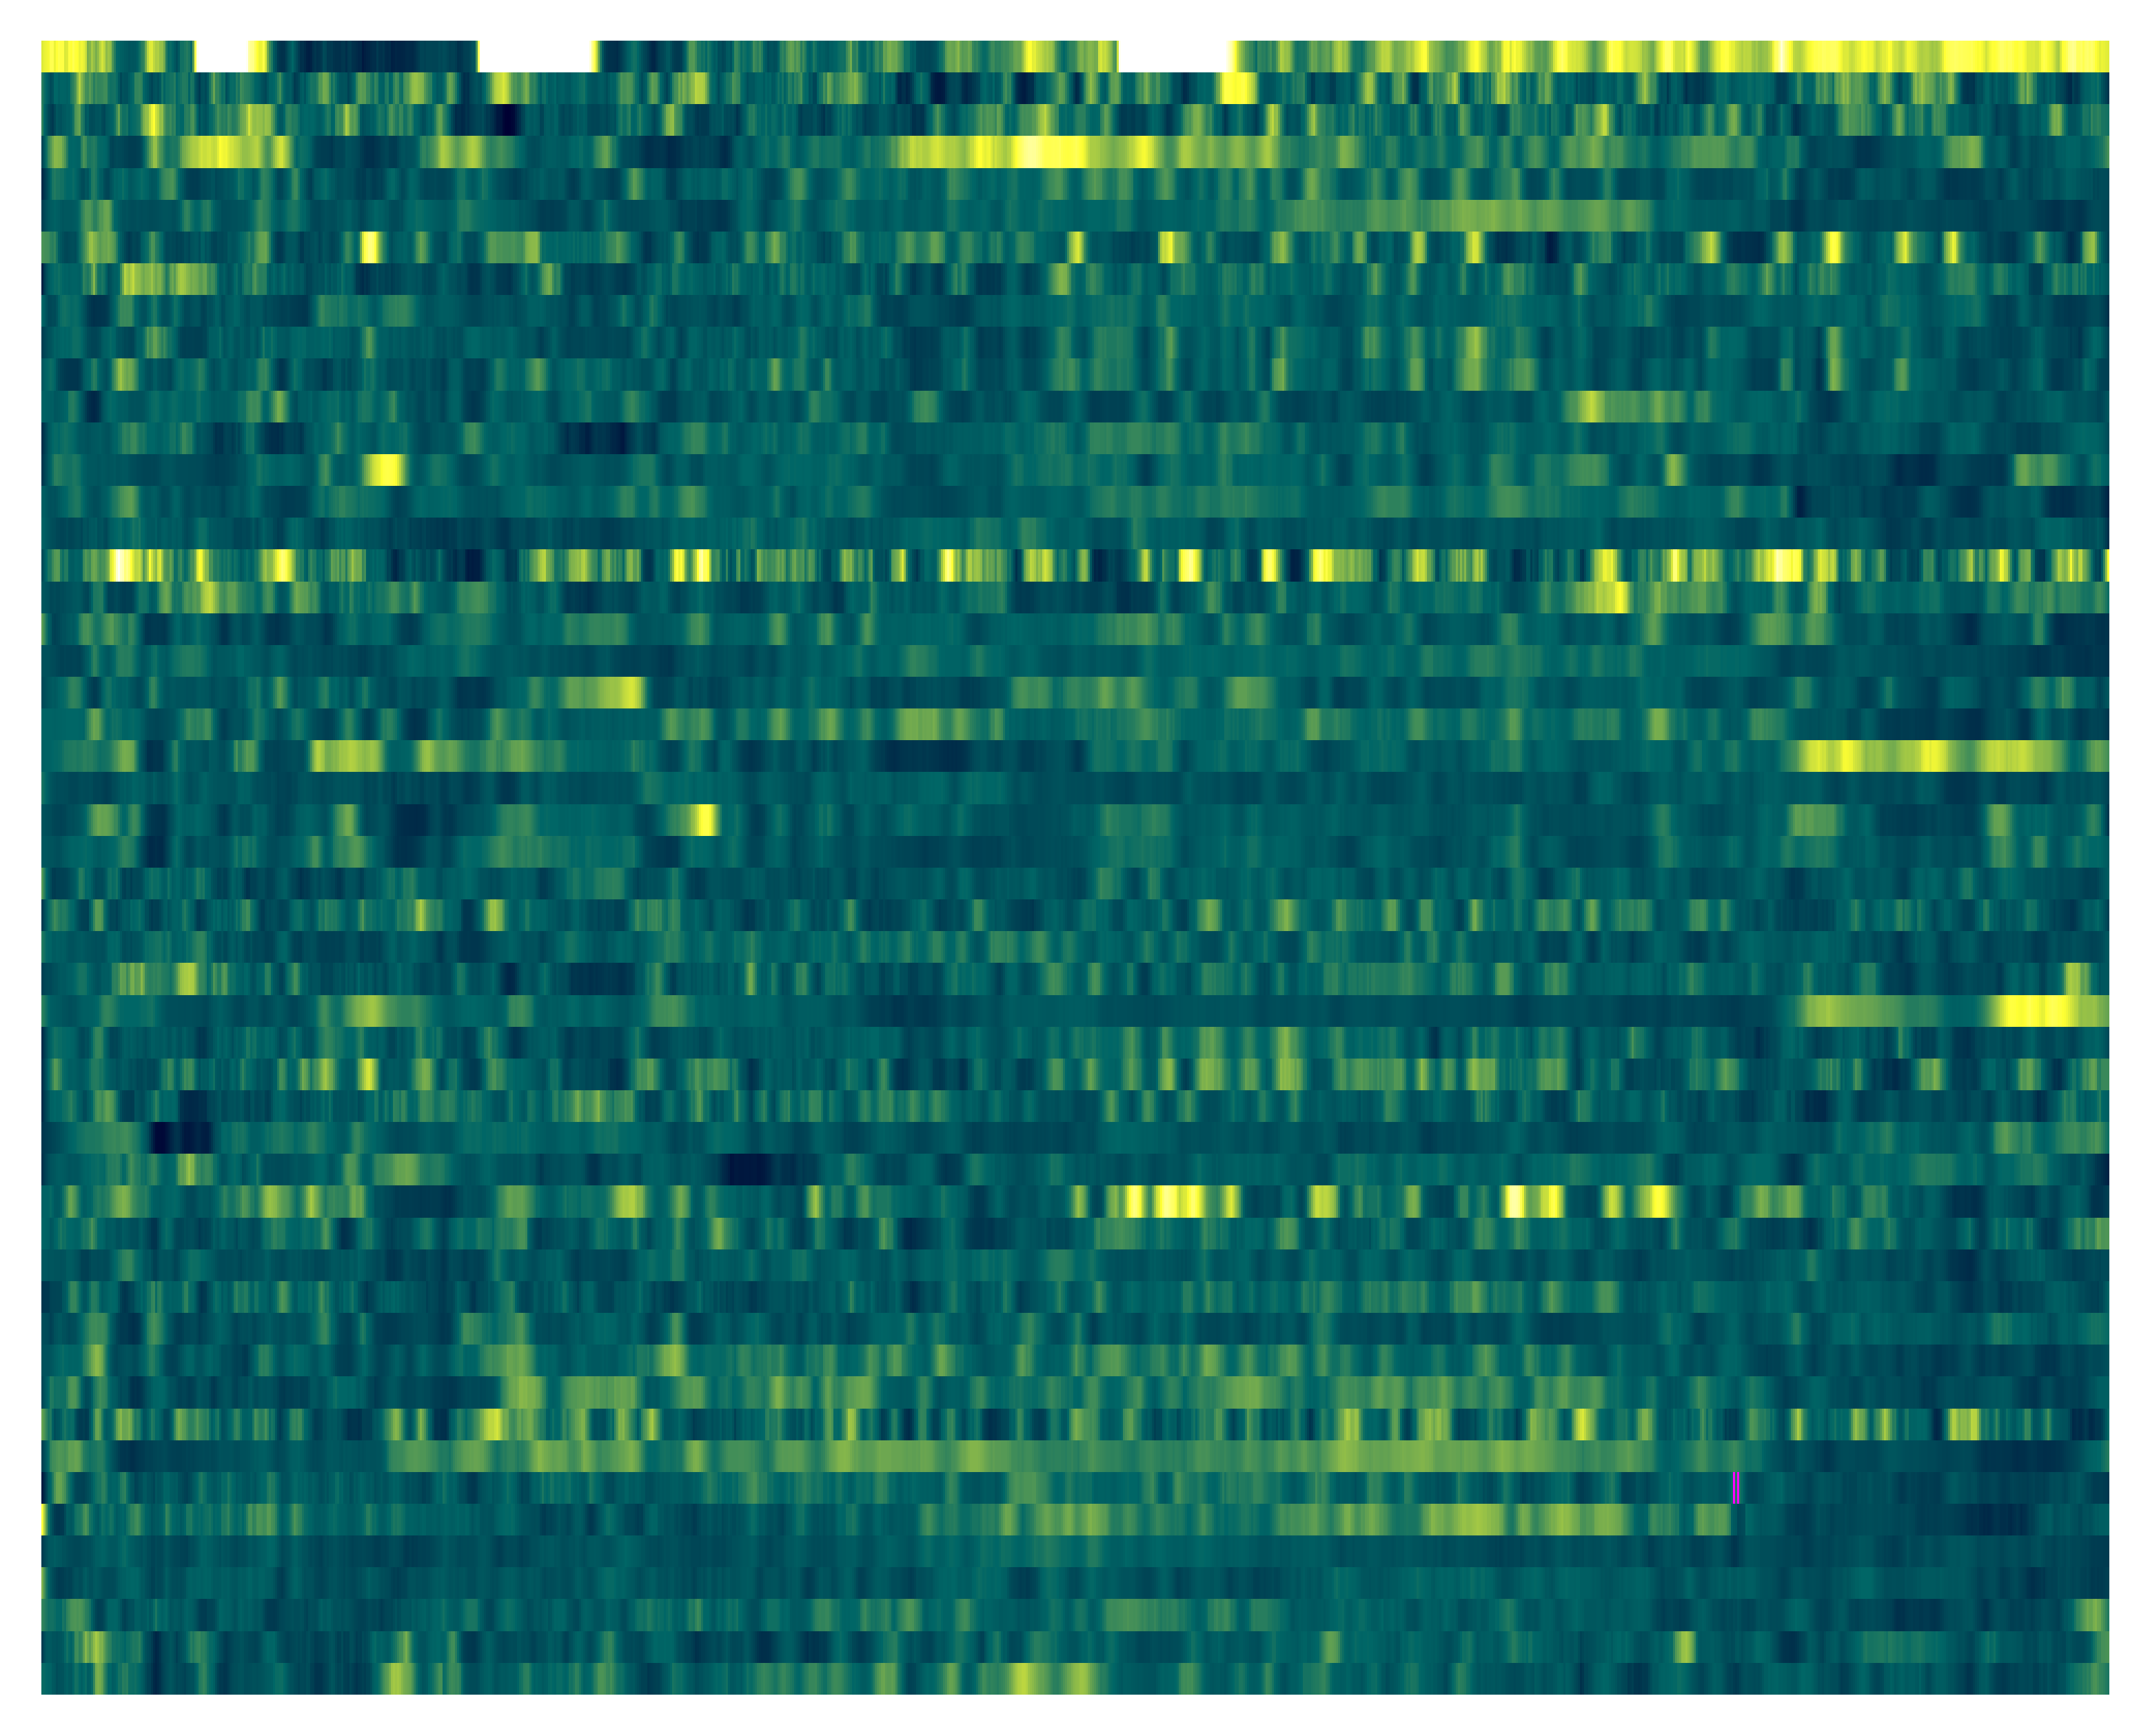

✅ ヒートマップデータをCSV保存: output_heatmaps\20250819\heatmap_ratio_10mW-4_v2_bleach_corrected_win7_pNaN.csv


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from datetime import datetime

# === データ読み込み ===
filename = "ratio_10mW-4_v2_bleach_corrected_win7_pNaN"
df = pd.read_csv(f"{filename}.csv")
time = df['timing'].to_numpy()
cell_labels = [col for col in df.columns if col.startswith("cell")]

# === ΔR/R₀ 計算関数 ===
def compute_dR_R0(series, method="percentile10"):
    if method.startswith("percentile"):
        p = int(method.replace("percentile", ""))
        R0 = np.nanpercentile(series, p)
        return (series - R0) / R0
    else:
        raise ValueError(f"Unsupported method: {method}")


# === 4色指定カラーマップ作成関数（NaN値対応版）===
def create_four_color_cmap_narrow_max_fixed(data, colors, white_threshold=1, vmin=None, vmax=None, n_colors=256):
    """
    手動vmax設定に対応した修正版
    """
    
    # vmin, vmaxが指定されていない場合はデータから計算
    if vmin is None:
        vmin = np.nanmin(data)
    if vmax is None:
        vmax = np.nanmax(data)
    
    # 白色閾値の計算（vmaxとの整合性を保つ）
    data_max = np.nanmax(data)
    
    if white_threshold == 1.0:
        # white_threshold=1.0の場合、vmaxを白色閾値として使用
        white_value = vmax
        print(f"✅ 手動vmax使用: 白色閾値 = {white_value:.3f}")
    else:
        # white_threshold < 1.0の場合、データから計算
        white_value = np.nanpercentile(data, white_threshold * 100)
        # ただし、vmaxを超えないように制限
        white_value = min(white_value, vmax)
        print(f"✅ 調整後白色閾値: {white_value:.3f} (制限: vmax={vmax:.3f})")
    
    # vmaxを超えるデータの警告
    over_vmax_count = np.sum(data > vmax)
    if over_vmax_count > 0:
        print(f"⚠️ 警告: {over_vmax_count} ピクセルがvmax({vmax:.3f})を超過")
        print(f"   → これらは白色で表示されます")
    
    # 四分位点計算（vmin～vmax範囲内で）
    clipped_data = np.clip(data, vmin, vmax)
    q1 = np.nanpercentile(clipped_data, 25)
    q2 = np.nanpercentile(clipped_data, 50)
    q3 = white_value
    quartiles = [vmin, q1, q2, q3, vmax]
    
    # 区間のピクセル数計算
    if white_threshold == 1.0:
        # 最大値のみ白色の場合
        white_pixels = max(1, int(n_colors * 0.01))  # 最低1%は白色用に確保
    else:
        white_pixels = int(n_colors * (1 - white_threshold))
    
    gradient_pixels = n_colors - white_pixels
    segment_size = gradient_pixels // 3
    
    segments = [segment_size] * 3 + [white_pixels]
    
    # 残りの分配
    remaining = gradient_pixels % 3
    for i in range(remaining):
        segments[i] += 1
    
    # 色の配列
    color1 = np.array(colors[0])  # 最小値色
    color2 = np.array(colors[1])  # 中間低色
    color3 = np.array(colors[2])  # 中間高色
    color4 = np.array(colors[3])  # 最大値色（白）
    
    # グラデーション作成
    gradients = []
    
    for i, (start_color, end_color, seg_size) in enumerate([
        (color1, color2, segments[0]),
        (color2, color3, segments[1]),
        (color3, color4, segments[2])
    ]):
        if seg_size > 0:
            grad = np.array([
                start_color * (1 - t) + end_color * t 
                for t in np.linspace(0, 1, seg_size)
            ])
            gradients.append(grad)
    
    # 白色区間
    if segments[3] > 0:
        grad4 = np.array([color4] * segments[3])
        gradients.append(grad4)
    
    # カラーマップ作成
    full_gradient = np.vstack(gradients)
    cmap = ListedColormap(full_gradient, name="four_color_narrow_max_fixed")
    cmap.set_bad(color='magenta')
    
    return cmap, vmin, vmax, quartiles


# === データ処理 ===
dR_R0 = np.array([compute_dR_R0(df[cell]) for cell in cell_labels])

# === セルソート ===
cell_label_nums = [int(c[4:]) for c in cell_labels]
label_to_index = {int(c[4:]): i for i, c in enumerate(cell_labels)}

# === 4色の定義 ===
white = np.array([1.0, 1.0, 1.0])
bright_yellow = np.array([1.0, 1.0, 0.2]) 
dark_cyan = np.array([0.0, 0.4, 0.4])
super_dark_blue = np.array([0.0, 0.0, 0.2])

# 使用する色セットを選択
selected_colors = [
    super_dark_blue,    # 濃い青（最小値）
    dark_cyan,    # 明るい青（第1四分位）
    bright_yellow,    # 薄い黄色（第3四分位）
    white     # 濃い黄色（最大値）
]

# === 修正版の使用例 ===
# 手動設定での使用
white_threshold = 1.0
vmin = np.nanmin(dR_R0)
vmax = 1.3  # 手動設定

custom_cmap, vmin, vmax, quartiles = create_four_color_cmap_narrow_max_fixed(
    dR_R0, selected_colors, 
    white_threshold=white_threshold, 
    vmin=vmin, 
    vmax=vmax, 
    n_colors=256
)

over_vmax_cells = []
for i, cell in enumerate(cell_labels):
    if np.any(dR_R0[i] > vmax):
        over_vmax_cells.append(cell)
print("cell_labels with data values above vmax:", over_vmax_cells)

# === ヒートマップ描画 ===
fig, ax = plt.subplots(figsize=(5, 4), dpi=600)
im = ax.imshow(dR_R0, aspect='auto', cmap=custom_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
# ax.set_title(f"cell_labels with data values above vmax:{over_vmax_cells}", fontsize=3)
# ax.set_yticks(np.arange(len(cell_labels)))
# ax.set_yticklabels(cell_labels, fontsize=3)
# ax.set_xticks([])
ax.axis('off')
ax.set_position([0, 0, 1, 1])

# # カラーバー
# cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('ΔR/R₀', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

# === 画像保存 ===
date_str = datetime.now().strftime("%Y%m%d")
output_dir = os.path.join("output_heatmaps", date_str)
os.makedirs(output_dir, exist_ok=True)

dpi=600
fig.savefig(
    os.path.join(
        output_dir,
        f"{filename}_vmax_{vmax}.tiff"
    ),
    dpi=dpi,
    bbox_inches='tight',
    pad_inches=0.0,  # パディングを0に設定
    format='tiff',
    edgecolor='none',                       # エッジなし
    pil_kwargs={                                
        "compression": "none",                  # 完全非圧縮
        "optimize": False,                       # 最適化無効（品質優先）
        "dpi": (dpi, dpi)
    }
)

csv_df = pd.DataFrame(dR_R0, index=cell_labels)
neuron_labels = [f"Neuron{i+1}" for i in range(len(cell_labels))]
csv_df.index = neuron_labels
csv_save_path = os.path.join(output_dir, f"heatmap_{filename}.csv")
csv_df.to_csv(csv_save_path, index=True, header=False)  # index=True に変更
print(f"✅ ヒートマップデータをCSV保存: {csv_save_path}")

Worm4, ratio_7mW-3.csv

✅ 手動vmax使用: 白色閾値 = 1.497
cell_labels with data values above vmax: []


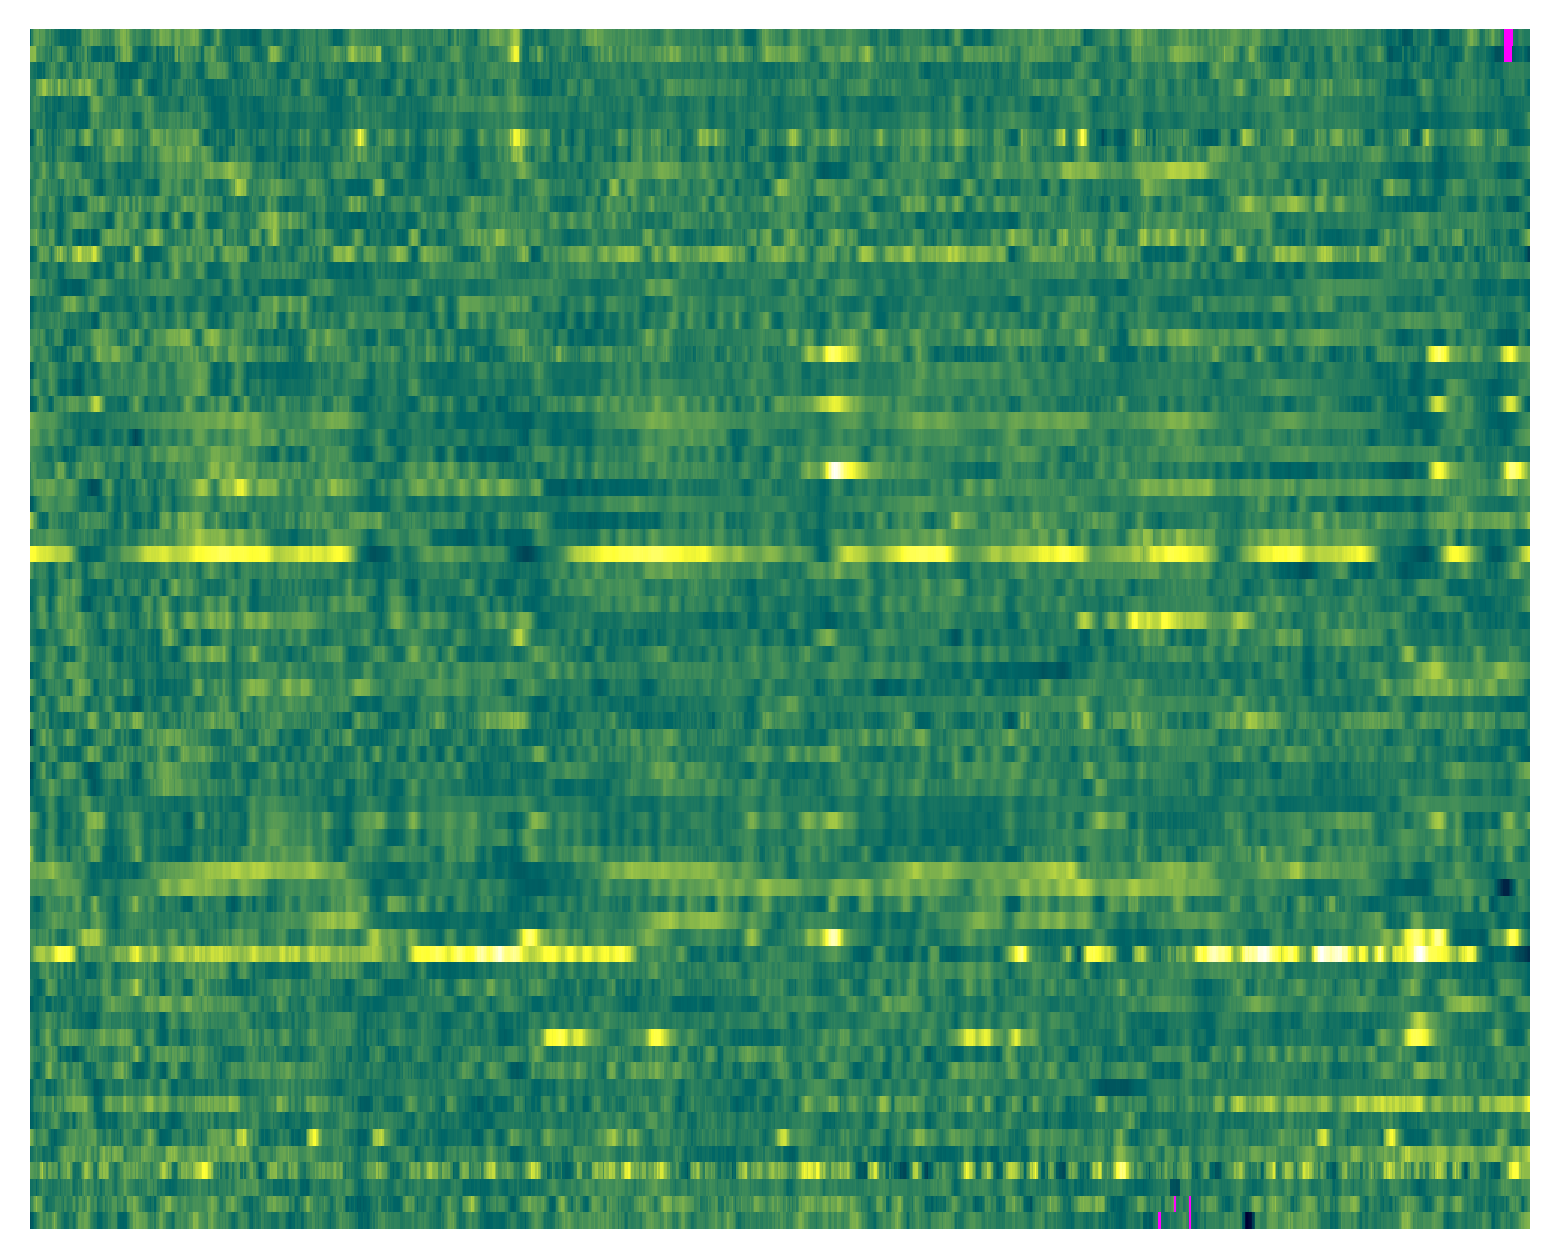

✅ ヒートマップデータをCSV保存: output_heatmaps\20250819\heatmap_ratio_7mW-3_bleach_corrected_win7_pNaN.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from datetime import datetime

# === データ読み込み ===
filename = "ratio_7mW-3_bleach_corrected_win7_pNaN"
df = pd.read_csv(f"{filename}.csv")
time = df['timing'].to_numpy()
cell_labels = [col for col in df.columns if col.startswith("cell")]

# === ΔR/R₀ 計算関数 ===
def compute_dR_R0(series, method="percentile10"):
    if method.startswith("percentile"):
        p = int(method.replace("percentile", ""))
        R0 = np.nanpercentile(series, p)
        return (series - R0) / R0
    else:
        raise ValueError(f"Unsupported method: {method}")


# === 4色指定カラーマップ作成関数（NaN値対応版）===
def create_four_color_cmap_narrow_max_fixed(data, colors, white_threshold=1, vmin=None, vmax=None, n_colors=256):
    """
    手動vmax設定に対応した修正版
    """
    
    # vmin, vmaxが指定されていない場合はデータから計算
    if vmin is None:
        vmin = np.nanmin(data)
    if vmax is None:
        vmax = np.nanmax(data)
    
    # 白色閾値の計算（vmaxとの整合性を保つ）
    data_max = np.nanmax(data)
    
    if white_threshold == 1.0:
        # white_threshold=1.0の場合、vmaxを白色閾値として使用
        white_value = vmax
        print(f"✅ 手動vmax使用: 白色閾値 = {white_value:.3f}")
    else:
        # white_threshold < 1.0の場合、データから計算
        white_value = np.nanpercentile(data, white_threshold * 100)
        # ただし、vmaxを超えないように制限
        white_value = min(white_value, vmax)
        print(f"✅ 調整後白色閾値: {white_value:.3f} (制限: vmax={vmax:.3f})")
    
    # vmaxを超えるデータの警告
    over_vmax_count = np.sum(data > vmax)
    if over_vmax_count > 0:
        print(f"⚠️ 警告: {over_vmax_count} ピクセルがvmax({vmax:.3f})を超過")
        print(f"   → これらは白色で表示されます")
    
    # 四分位点計算（vmin～vmax範囲内で）
    clipped_data = np.clip(data, vmin, vmax)
    q1 = np.nanpercentile(clipped_data, 25)
    q2 = np.nanpercentile(clipped_data, 50)
    q3 = white_value
    quartiles = [vmin, q1, q2, q3, vmax]
    
    # 区間のピクセル数計算
    if white_threshold == 1.0:
        # 最大値のみ白色の場合
        white_pixels = max(1, int(n_colors * 0.01))  # 最低1%は白色用に確保
    else:
        white_pixels = int(n_colors * (1 - white_threshold))
    
    gradient_pixels = n_colors - white_pixels
    segment_size = gradient_pixels // 3
    
    segments = [segment_size] * 3 + [white_pixels]
    
    # 残りの分配
    remaining = gradient_pixels % 3
    for i in range(remaining):
        segments[i] += 1
    
    # 色の配列
    color1 = np.array(colors[0])  # 最小値色
    color2 = np.array(colors[1])  # 中間低色
    color3 = np.array(colors[2])  # 中間高色
    color4 = np.array(colors[3])  # 最大値色（白）
    
    # グラデーション作成
    gradients = []
    
    for i, (start_color, end_color, seg_size) in enumerate([
        (color1, color2, segments[0]),
        (color2, color3, segments[1]),
        (color3, color4, segments[2])
    ]):
        if seg_size > 0:
            grad = np.array([
                start_color * (1 - t) + end_color * t 
                for t in np.linspace(0, 1, seg_size)
            ])
            gradients.append(grad)
    
    # 白色区間
    if segments[3] > 0:
        grad4 = np.array([color4] * segments[3])
        gradients.append(grad4)
    
    # カラーマップ作成
    full_gradient = np.vstack(gradients)
    cmap = ListedColormap(full_gradient, name="four_color_narrow_max_fixed")
    cmap.set_bad(color='magenta')
    
    return cmap, vmin, vmax, quartiles


# === データ処理 ===
dR_R0 = np.array([compute_dR_R0(df[cell]) for cell in cell_labels])

# === セルソート ===
cell_label_nums = [int(c[4:]) for c in cell_labels]
label_to_index = {int(c[4:]): i for i, c in enumerate(cell_labels)}

# === 4色の定義 ===
white = np.array([1.0, 1.0, 1.0])
bright_yellow = np.array([1.0, 1.0, 0.2]) 
dark_cyan = np.array([0.0, 0.4, 0.4])
super_dark_blue = np.array([0.0, 0.0, 0.2])

# 使用する色セットを選択
selected_colors = [
    super_dark_blue,    # 濃い青（最小値）
    dark_cyan,    # 明るい青（第1四分位）
    bright_yellow,    # 薄い黄色（第3四分位）
    white     # 濃い黄色（最大値）
]

# === 修正版の使用例 ===
# 手動設定での使用
white_threshold = 1.0
vmin = np.nanmin(dR_R0)
vmax = None  # 手動設定
# vmax = 2  # 手動設定

custom_cmap, vmin, vmax, quartiles = create_four_color_cmap_narrow_max_fixed(
    dR_R0, selected_colors, 
    white_threshold=white_threshold, 
    vmin=vmin, 
    vmax=vmax, 
    n_colors=256
)

over_vmax_cells = []
for i, cell in enumerate(cell_labels):
    if np.any(dR_R0[i] > vmax):
        over_vmax_cells.append(cell)
print("cell_labels with data values above vmax:", over_vmax_cells)

# === ヒートマップ描画 ===
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
im = ax.imshow(dR_R0, aspect='auto', cmap=custom_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
# ax.set_title(f"cell_labels with data values above vmax:{over_vmax_cells}", fontsize=3)
# ax.set_yticks(np.arange(len(cell_labels)))
# ax.set_yticklabels(cell_labels, fontsize=3)
# ax.set_xticks([])
ax.axis('off')
# プロット領域を図全体に設定
ax.set_position([0, 0, 1, 1])

# # カラーバー
# cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('ΔR/R₀', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

# === 画像保存 ===
date_str = datetime.now().strftime("%Y%m%d")
output_dir = os.path.join("output_heatmaps", date_str)
os.makedirs(output_dir, exist_ok=True)

dpi=600
fig.savefig(
    os.path.join(
        output_dir,
        f"{filename}_vmax_{vmax}.tiff"
    ),
    dpi=dpi,
    bbox_inches='tight',
    pad_inches=0.0,  # パディングを0に設定
    format='tiff',
    edgecolor='none',                       # エッジなし
    pil_kwargs={                                
        "compression": "none",                  # 完全非圧縮
        "optimize": False,                       # 最適化無効（品質優先）
        "dpi": (dpi, dpi)
    }
)

csv_df = pd.DataFrame(dR_R0, index=cell_labels)
neuron_labels = [f"Neuron{i+1}" for i in range(len(cell_labels))]
csv_df.index = neuron_labels
csv_save_path = os.path.join(output_dir, f"heatmap_{filename}.csv")
csv_df.to_csv(csv_save_path, index=True, header=False)  # index=True に変更
print(f"✅ ヒートマップデータをCSV保存: {csv_save_path}")